In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

/home/mmiihkin/miniconda3/envs/scanpy311/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [14]:
# Zuckerberg trophoblast dataset
file_path = Path.home() / "Downloads" / "scvi_integrated_10000hvgs.h5ad"

# Load the AnnData object
adata = sc.read_h5ad(file_path)

In [3]:
adata.obs.columns

Index(['doublet_score', 'is_doublet', 'n_genes', 'n_genes_by_counts',
       'pct_counts_mt', 'total_counts', 'total_counts_mt', 'bbknn_leiden',
       'sample', '_scvi_batch', '_scvi_labels', 'leiden_0.5', 'leiden_1.0',
       'leiden_1.5'],
      dtype='object')

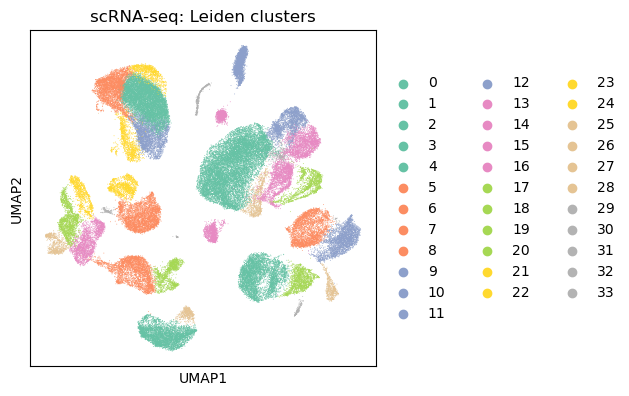

KeyError: 'Could not find key cell_type in .var_names or .obs.columns.'

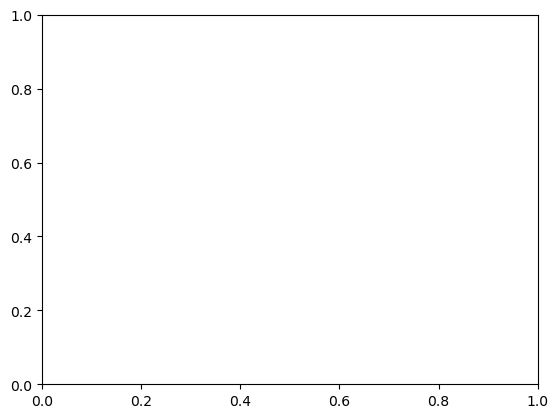

In [38]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.leiden(adata, resolution=1.0, key_added="leiden_1.0")
sc.tl.umap(adata, random_state=0)
ax = sc.pl.umap(
    adata,
    color="leiden_1.0",
    palette="Set2",
    legend_loc="right margin",
    title="scRNA-seq: Leiden clusters",
    show=False
)

import matplotlib.pyplot as plt
# Rasterize only the point cloud(s)
for coll in ax.collections:
    coll.set_rasterized(True)

plt.tight_layout()
ax.set_aspect("equal")
plt.savefig("umap_scVI10000genes_scRNAseq_cluster.svg", bbox_inches="tight")
plt.show()

ax = sc.pl.umap(
    adata,
    color="cell_type",
    palette="Set2",
    legend_loc="right margin",
    title="scRNA-seq: Leiden clusters",
    show=False
)

import matplotlib.pyplot as plt
# Rasterize only the point cloud(s)
for coll in ax.collections:
    coll.set_rasterized(True)

plt.tight_layout()
ax.set_aspect("equal")
plt.savefig("umap_scVI1000genes_scRNAseq_celltype.svg", bbox_inches="tight")
plt.show()

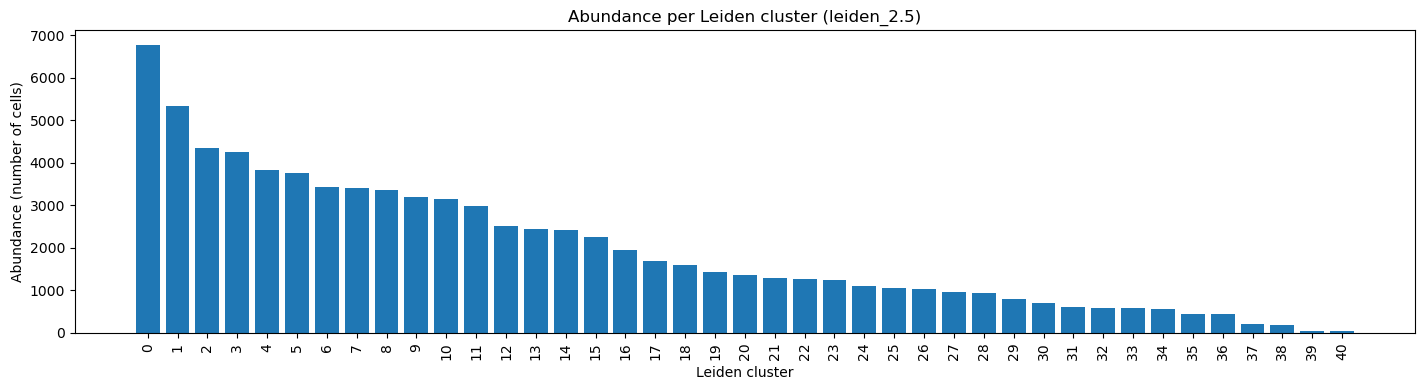

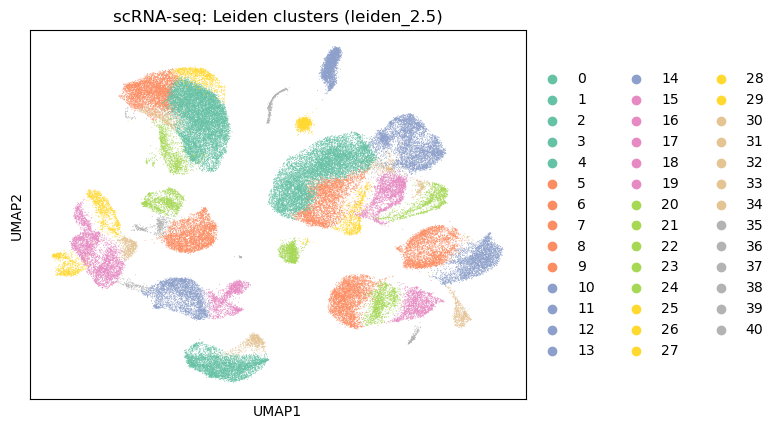

In [54]:
# =========================================================
# 1) Barplot: abundance (cell count) per Leiden cluster
# =========================================================
cluster_key = "leiden_1.5"

# counts per cluster (ensure consistent ordering by cluster id)
counts = adata.obs[cluster_key].value_counts()
# sort nicely if clusters are numeric-like strings
try:
    counts = counts.reindex(sorted(counts.index, key=lambda x: int(x)))
except Exception:
    counts = counts.sort_index()

fig, ax = plt.subplots(figsize=(max(8, 0.35 * len(counts)), 4))
ax.bar(counts.index.astype(str), counts.values)
ax.set_xlabel("Leiden cluster")
ax.set_ylabel("Abundance (number of cells)")
ax.set_title("Abundance per Leiden cluster (leiden_2.5)")
ax.tick_params(axis="x", labelrotation=90)
plt.tight_layout()
plt.show()

# (optional) save
# fig.savefig("leiden_2_5_cluster_abundance.png", dpi=300, bbox_inches="tight")

# =========================================================
# 2) UMAP: highlight cluster "40" (others grey)
# =========================================================
highlight_cluster = "40"  # Leiden labels are usually strings

# Create a highlight label column: "40" vs "Other"
hl_key = f"{cluster_key}_highlight_{highlight_cluster}"
adata.obs[hl_key] = np.where(adata.obs[cluster_key].astype(str) == str(highlight_cluster),
                             f"Cluster {highlight_cluster}",
                             "Other")

# Plot with custom colors: grey for others, bright for highlighted
# (Scanpy accepts a list of colors aligned to categorical order)
adata.obs[hl_key] = adata.obs[hl_key].astype("category")
# Force category order so "Other" is first (grey) and highlighted second
adata.obs[hl_key] = adata.obs[hl_key].cat.reorder_categories(["Other", f"Cluster {highlight_cluster}"], ordered=True)

import matplotlib.pyplot as plt
import scanpy as sc

fig, ax = plt.subplots(figsize=(10, 6))

ax = sc.pl.umap(
    adata,
    color=hl_key,
    palette=["lightgrey", "red"],
    legend_loc="right margin",
    title=f"UMAP: highlight Leiden cluster {highlight_cluster}",
    size=10,
    ax=ax,
    show=False
)

# Rasterize all point collections
for coll in ax.collections:
    coll.set_rasterized(True)

plt.tight_layout()

# Save (vector text + rasterized points)
fig.savefig(
    f"umap_highlight_cluster_{highlight_cluster}_rasterized.svg",
    dpi=600,
    bbox_inches="tight"
)

# Optional PNG
fig.savefig(
    f"umap_highlight_cluster_{highlight_cluster}_rasterized.png",
    dpi=300,
    bbox_inches="tight"
)

plt.close(fig)


# =========================================================
# (Optional) also show your original multi-cluster UMAP
# =========================================================
sc.pl.umap(
    adata,
    color=cluster_key,
    palette="Set2",
    legend_loc="right margin",
    title="scRNA-seq: Leiden clusters (leiden_2.5)"
)

In [43]:
cluster_key = "leiden_1.5"
sample_key = "sample"
target_cluster = "40"   # Leiden labels are usually strings

# subset to cluster 40
cells_40 = adata.obs[adata.obs[cluster_key].astype(str) == target_cluster]

# number of unique samples where cluster 40 appears
n_samples_with_40 = cells_40[sample_key].nunique()

print(f"Leiden cluster {target_cluster} is detected in {n_samples_with_40} samples.")


Leiden cluster 40 is detected in 2 samples.


In [33]:

import pandas as pd
ct = pd.crosstab(
    adata.obs["leiden_2.0"],
    adata.obs["sample"]
)

ct

ctab_binary = (ct > 0).astype(int)

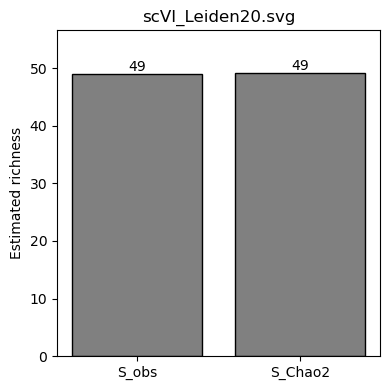

In [35]:
plot_chao2_barplot(ctab_binary, name="scVI_Leiden20.svg")

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def chao2(ctab_binary, axis=1):
    incidence = np.sum(ctab_binary, axis=axis)

    S_obs = np.sum(incidence > 0)
    Q1 = np.sum(incidence == 1)
    Q2 = np.sum(incidence == 2)

    S_Chao2 = S_obs + (Q1**2) / (2 * Q2) if Q2 > 0 else S_obs

    return S_obs, Q1, Q2, S_Chao2

def plot_chao2_barplot(ctab_binary, name, axis=1):
    S_obs, _, _, S_Chao2 = chao2(ctab_binary, axis=axis)

    values = [S_obs, S_Chao2]
    labels = ["S_obs", "S_Chao2"]

    plt.figure(figsize=(4, 4))

    bars = plt.bar(
        labels,
        values,
        color="gray",
        edgecolor="black"
    )

    plt.ylabel("Estimated richness")
    plt.title(name)

    # Force y-axis to start at 0 and show full range
    ymax = max(values) * 1.15
    plt.ylim(0, ymax)

    # ✅ Add numbers on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(round(height))}",
            ha="center",
            va="bottom"
        )

    plt.tight_layout()
    plt.savefig(f"{name}_chao2_barplot.svg", bbox_inches="tight")
    plt.show()

In [17]:
# Python/Scanpy translation of the R code (AnnData + pandas/numpy/matplotlib)
# -----------------------------------------------------------------------------
# Requirements:
#   pip install scanpy anndata pandas numpy matplotlib
#
# Assumptions:
#   - You already have an AnnData object `adata`
#   - adata.obs has columns:
#       * 'sample' (sample ID per cell)
#       * 'bbknn_leiden' (cluster label per cell; change if needed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Helper: Chao2 estimator
# -------------------------------
def calc_chao2(binary_mat: np.ndarray) -> dict:
    """
    binary_mat: 2D array of shape (n_samples, n_clusters) with 0/1 presence/absence
    Returns dict with S_chao2, S_obs, Q1, Q2
    """
    species_counts = binary_mat.sum(axis=0)     # across samples, per cluster
    Q1 = int(np.sum(species_counts == 1))
    Q2 = int(np.sum(species_counts == 2))
    S_obs = int(np.sum(species_counts > 0))
    if Q2 > 0:
        S_chao2 = float(S_obs + (Q1 ** 2) / (2 * Q2))
    else:
        S_chao2 = float(S_obs)
    return {"S_chao2": S_chao2, "S_obs": S_obs, "Q1": Q1, "Q2": Q2}

# -------------------------------
# Main: bootstrap across sample sizes
# -------------------------------
def chao2_stability(
    adata,
    sample_col: str = "sample",
    cluster_col: str = "bbknn_leiden",
    n_boot: int = 500,
    seed: int = 42,
    min_samples: int = 3,
) -> pd.DataFrame:
    """
    Replicates the R workflow:
      For each sample size n_samp, repeatedly subsample samples (without replacement),
      compute presence/absence table sample x cluster, estimate observed clusters and Chao2,
      then summarize mean/sd across bootstraps.
    """
    rng = np.random.default_rng(seed)

    meta = adata.obs[[sample_col, cluster_col]].copy()

    # Optional: drop NA cluster labels to avoid treating NaN as a cluster
    meta = meta.dropna(subset=[cluster_col])

    all_samples = meta[sample_col].unique()
    if len(all_samples) < min_samples:
        raise ValueError(f"Need at least {min_samples} unique samples; found {len(all_samples)}.")

    nsamps = range(min_samples, len(all_samples) + 1)

    rows = []
    for n_samp in nsamps:
        print(f"🔄  Processing sample size {n_samp:2d} / {max(nsamps):2d} …")

        obs_vals = np.empty(n_boot, dtype=float)
        chao2_vals = np.empty(n_boot, dtype=float)

        for b in range(n_boot):
            sel = rng.choice(all_samples, size=n_samp, replace=False)
            submd = meta[meta[sample_col].isin(sel)]

            # Contingency table: sample x cluster
            ctab = pd.crosstab(submd[sample_col], submd[cluster_col])

            # Presence/absence matrix
            binmat = (ctab.values > 0).astype(np.int64)

            ch = calc_chao2(binmat)
            obs_vals[b] = ch["S_obs"]
            chao2_vals[b] = ch["S_chao2"]

        rows.append(
            {
                "sample_size": n_samp,
                "obs_mean": float(np.mean(obs_vals)),
                "obs_sd": float(np.std(obs_vals, ddof=1)),
                "chao2_mean": float(np.mean(chao2_vals)),
                "chao2_sd": float(np.std(chao2_vals, ddof=1)),
            }
        )

    return pd.DataFrame(rows)

# -------------------------------
# Plot (matplotlib) and save SVG
# -------------------------------
def plot_chao2_stability(results: pd.DataFrame, out_svg: str = "Chao2_stability_Yevhen.svg"):
    x = results["sample_size"].to_numpy()

    # Observed clusters
    y_obs = results["obs_mean"].to_numpy()
    y_obs_lo = (results["obs_mean"] - results["obs_sd"]).to_numpy()
    y_obs_hi = (results["obs_mean"] + results["obs_sd"]).to_numpy()

    # Chao2 estimate
    y_chao = results["chao2_mean"].to_numpy()
    y_chao_lo = (results["chao2_mean"] - results["chao2_sd"]).to_numpy()
    y_chao_hi = (results["chao2_mean"] + results["chao2_sd"]).to_numpy()

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(x, y_obs, label="Observed clusters")
    ax.fill_between(x, y_obs_lo, y_obs_hi, alpha=0.2)

    ax.plot(x, y_chao, label="Chao2 estimate")
    ax.fill_between(x, y_chao_lo, y_chao_hi, alpha=0.2)

    ax.set_xlabel("Number of Samples")
    ax.set_ylabel("Number of Clusters")
    ax.set_title("Stability of Chao2 Completeness Estimation")
    ax.legend(loc="upper left")
    ax.grid(False)

    fig.tight_layout()
    fig.savefig(out_svg, format="svg")
    plt.close(fig)

# -------------------------------
# Example usage
# -------------------------------
# results = chao2_stability(adata, sample_col="sample", cluster_col="bbknn_leiden",
#                           n_boot=500, seed=42, min_samples=3)
# plot_chao2_stability(results, out_svg="Chao2_stability_Yevhen.svg")
# results.to_csv("Chao2_stability_Yevhen.csv", index=False)


In [44]:
results = chao2_stability(adata, sample_col="sample", cluster_col="leiden_1.0",
                           n_boot=500, seed=42, min_samples=3)
plot_chao2_stability(results, out_svg="Chao2_stability_scvi_emani_scVI_10k_Leiden10.svg")
results.to_csv("Chao2_stability_scvi_emani_scVI_10k_Leiden10.csv", index=False)

🔄  Processing sample size  3 / 18 …
🔄  Processing sample size  4 / 18 …
🔄  Processing sample size  5 / 18 …
🔄  Processing sample size  6 / 18 …
🔄  Processing sample size  7 / 18 …
🔄  Processing sample size  8 / 18 …
🔄  Processing sample size  9 / 18 …
🔄  Processing sample size 10 / 18 …
🔄  Processing sample size 11 / 18 …
🔄  Processing sample size 12 / 18 …
🔄  Processing sample size 13 / 18 …
🔄  Processing sample size 14 / 18 …
🔄  Processing sample size 15 / 18 …
🔄  Processing sample size 16 / 18 …
🔄  Processing sample size 17 / 18 …
🔄  Processing sample size 18 / 18 …


Using batch_key='sample', label_key='leiden_2.0', use_rep='X_scVI'


/home/mmiihkin/miniconda3/envs/scanpy311/lib/python3.11/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/home/mmiihkin/miniconda3/envs/scanpy311/lib/python3.11/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/home/mmiihkin/miniconda3/envs/scanpy311/lib/python3.11/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/home/mmiihkin/miniconda3/envs/scanpy311/lib/python3.11/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed 

      iLISI  graph_connectivity batch_key label_key_proxy use_rep
0  0.180377                 1.0    sample      leiden_2.0  X_scVI


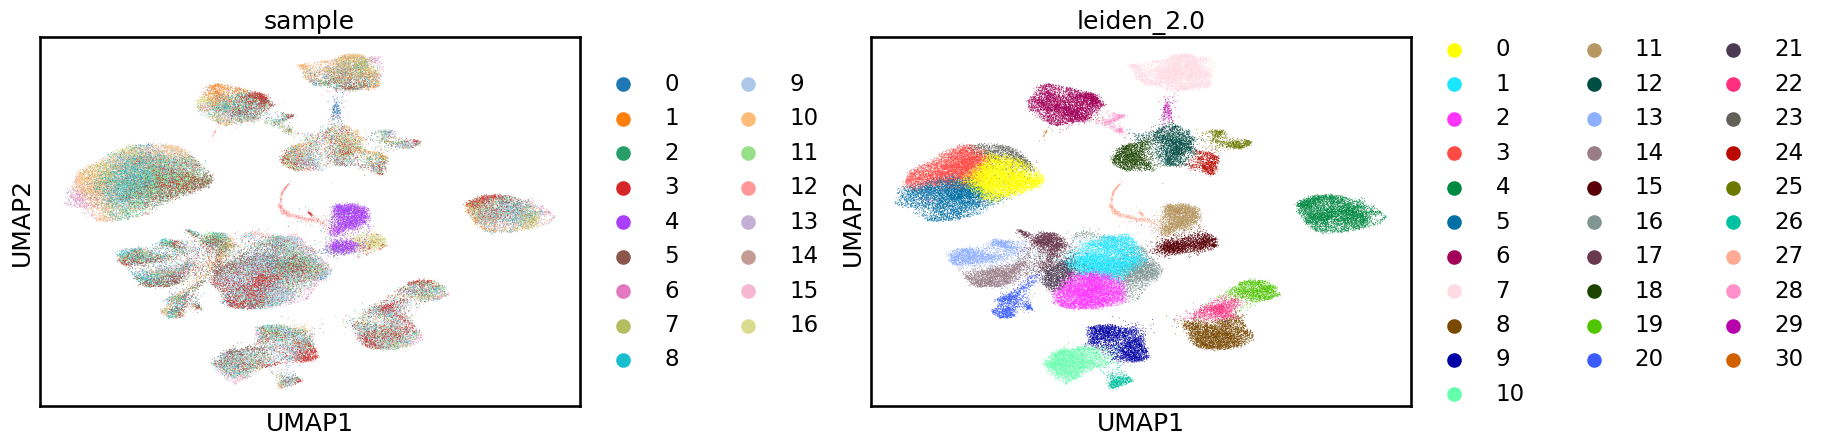

In [8]:
import scanpy as sc
import scib
import pandas as pd

# -----------------------------
# Choose keys from your AnnData
# -----------------------------
batch_key = "sample"

# Cluster labels as proxy "biology labels"
if "bbknn_leiden" in adata.obs.columns:
    label_key = "leiden_2.0"
elif "leiden_1.0" in adata.obs.columns:
    label_key = "leiden_1.0"
else:
    label_key = "leiden_0.5"

# Prefer integrated embedding
preferred_reps = ["X_scVI", "X_latent", "X_harmony", "X_pca"]
use_rep = next((r for r in preferred_reps if r in adata.obsm), None)
if use_rep is None:
    raise ValueError(f"No embedding found in adata.obsm. Have: {list(adata.obsm.keys())}")

print(f"Using batch_key='{batch_key}', label_key='{label_key}', use_rep='{use_rep}'")

# -----------------------------
# Make sure obs columns are categorical (fixes .cat error)
# -----------------------------
adata.obs[batch_key] = adata.obs[batch_key].astype("category")
adata.obs[label_key] = adata.obs[label_key].astype("category")

# -----------------------------
# Neighbors + UMAP on chosen embedding
# -----------------------------
sc.pp.neighbors(adata, use_rep=use_rep, n_neighbors=15)
sc.tl.umap(adata)

# -----------------------------
# 1) iLISI (higher = better mixing)
# -----------------------------
ilisi = scib.me.ilisi_graph(
    adata,
    batch_key=batch_key,
    type_="embed",
    use_rep=use_rep
)

# -----------------------------
# 2) Graph connectivity (higher = better)
# NOTE: in your scib version, no batch_key argument is accepted.
# This metric is meant to be computed for biological labels; we use clusters as proxy.
# -----------------------------
gc = scib.me.graph_connectivity(
    adata,
    label_key=label_key
)

# -----------------------------
# Results
# -----------------------------
scores = pd.DataFrame([{
    "iLISI": float(ilisi),
    "graph_connectivity": float(gc),
    "batch_key": batch_key,
    "label_key_proxy": label_key,
    "use_rep": use_rep
}])

print(scores)

# -----------------------------
# Plots for sanity checking
# -----------------------------
sc.pl.umap(adata, color=[batch_key, label_key], wspace=0.4)


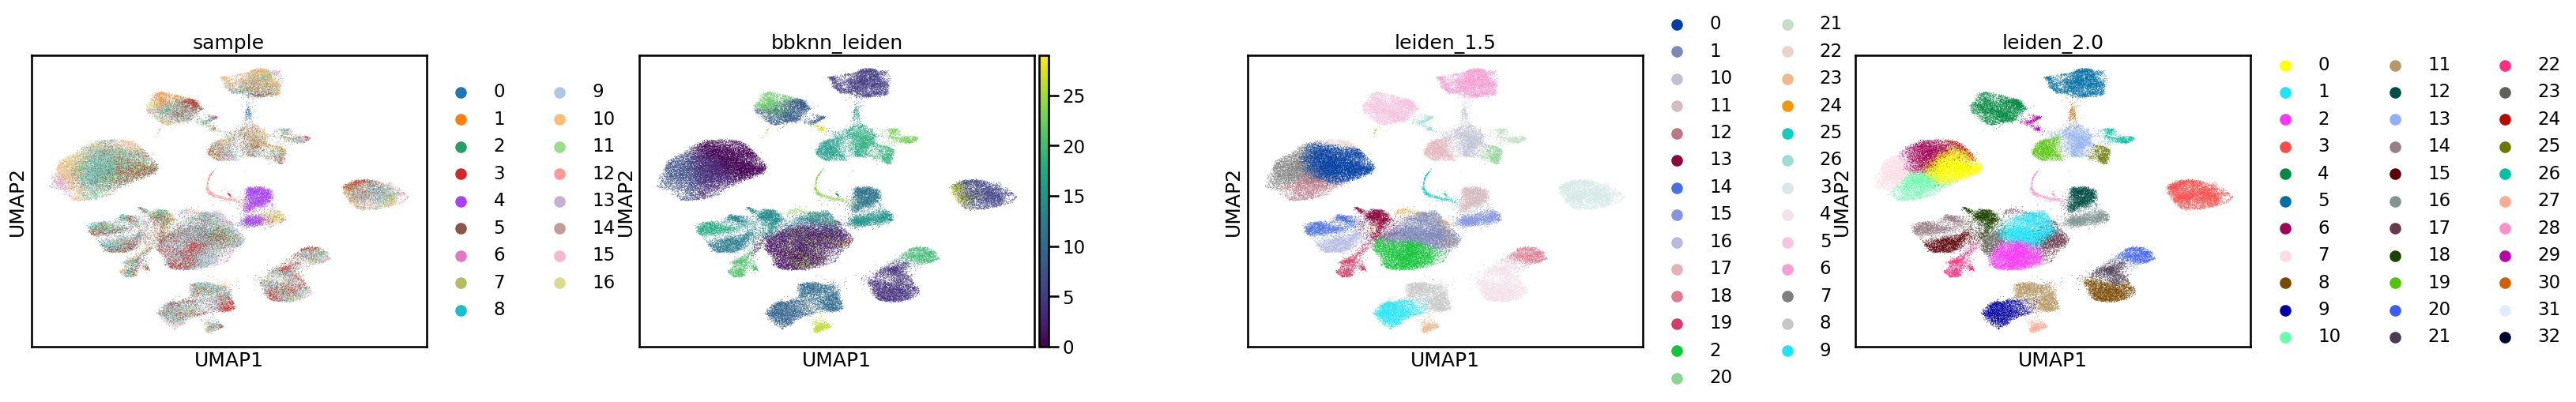

In [ ]:
import scanpy as sc

# UMAP from scVI latent space
use_rep = "X_scVI"   # this must exist in adata.obsm

sc.pp.neighbors(adata, use_rep=use_rep, n_neighbors=15)
sc.tl.umap(adata)

# Plot colored by batch and clusters (adjust as you like)
sc.pl.umap(
    adata,
    color=["sample", "leiden_1.5", "leiden_2.0", "leiden_2.5"],
    wspace=0.4
)


In [4]:
sc.tl.leiden(adata, resolution=2.5, key_added="leiden_2.5")
sc.tl.leiden(adata, resolution=2.0, key_added="leiden_2.0")

/tmp/ipykernel_2002747/3632284406.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=2.5, key_added="leiden_2.5")


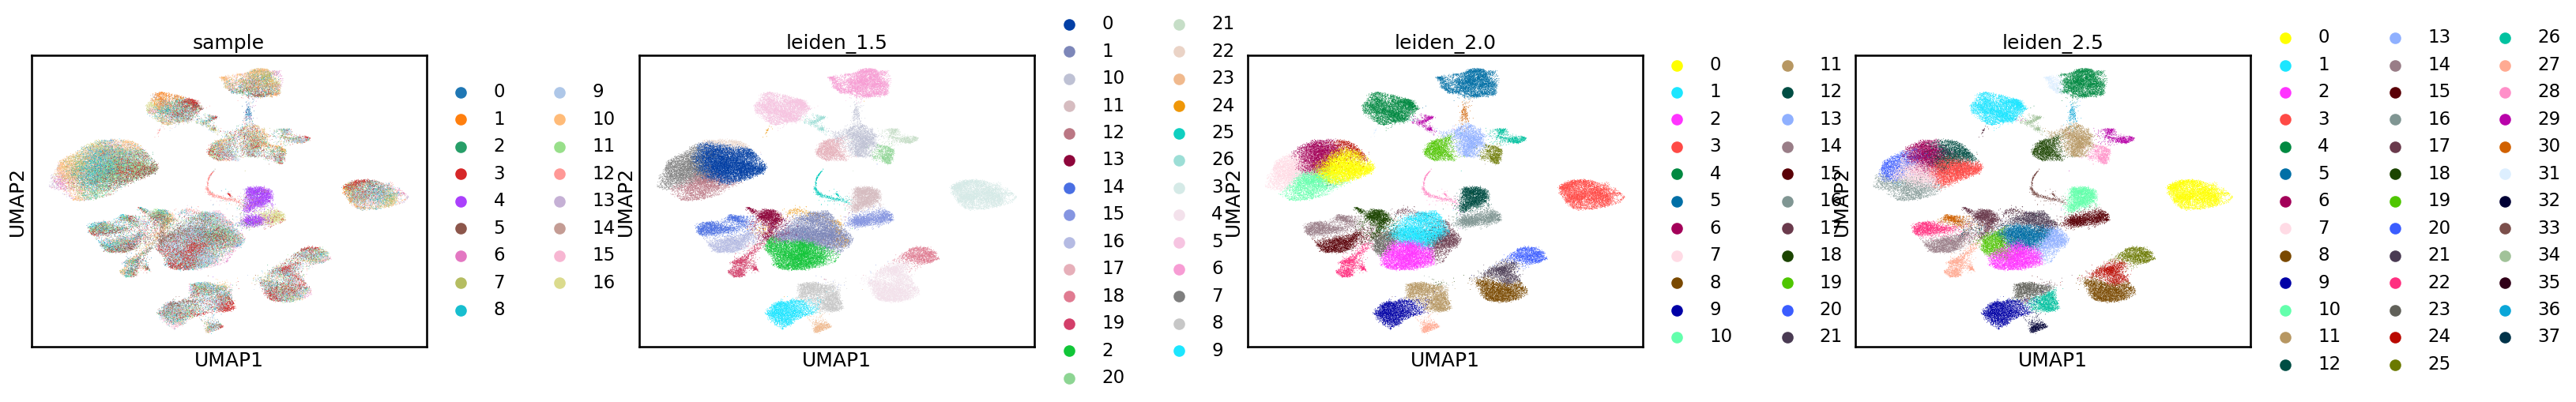

In [25]:
# Plot colored by batch and clusters (adjust as you like)
sc.pl.umap(
    adata,
    color=["sample", "leiden_1.5", "leiden_2.0", "leiden_2.5"],
    wspace=0.4
)